In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/MyDrive/updated_sec_phase'

/content/gdrive/MyDrive/updated_sec_phase


In [3]:
# to use GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split


x_data = np.loadtxt("x_data.csv",skiprows = 1, delimiter = ',', dtype = np.uint8) #load csv file 
x_data=x_data[0:67584] # to make data multiple of 256 to be accepted by the model 


y_data=np.loadtxt("y_data.csv",skiprows = 1, delimiter = ',', dtype = np.uint8)
y_data=y_data[0:67584] #  make data multiple of 256 to be accepted by the model

# y_data=pd.read_csv('y_data.csv') #read y inputs

#x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2) # split data into train and test
#know the shape of each dataset 
#print(x_data.shape) #=(54976, 36)
#print(y_train.shape) = (54976, 7)
#print(x_test.shape)  = (13744, 36)
#print(y_test.shape)  = (13744, 7)

In [6]:
#second phase 
#first i loaded the first phase model and made it untrainable
import numpy as np
num_of_train_data=67584 # to make data multiple of 256 to be accepted by the model 
time_step=36
seq_len=1
x_data = np.reshape(x_data, (num_of_train_data,time_step ,seq_len))
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
#model.add(LSTM(units=36, return_sequences=True, input_shape=(time_step, seq_len))) #first layer of the network has 36 neurons 
model.add(LSTM(units=36, return_sequences=True, input_shape=(36, seq_len))) #first layer of the network has 36 neurons 

model.add(LSTM(units=50))# second layer with 50 neurans 
model.add(Dense(units = 7, activation="sigmoid"))# used dense layer to make the output of the network has the same shape as real output which we will compare with( 7 bits) 

 
model.compile(optimizer = 'adam', loss = 'mean_squared_error') #to compile the model we used adam as optomizer and to calculate the loss between the network output and what is exist in the dataset(y_train)
#model.fit(x_train, y_train, batch_size=32,epochs=100, validation_split = 0.2, verbose=1,shuffle=True) #we split the training data to train and validation to prevent overfitting 
#Hint:change path to your path
model = keras.models.load_model('/content/gdrive/MyDrive/updated_sec_phase/model_weight99.79_.h5') #load the weights of the first weights 
model.trainable=False #make the first phase model untrainable 

print(model) #check that the model loaded 

In [7]:
#here we make a layer to carry the inital key and make it trainable 
#this layer called custom layer and the weights of it is the key 
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
from keras import backend as K 
from keras.layers import Layer


class MyCustomLayer(Layer): 
   def __init__(self, output_dim, **kwargs): 
      self.output_dim = output_dim 
      super(MyCustomLayer, self).__init__(**kwargs) 

   def build(self, input_shape): 
      self.kernel =  self.add_weight(name = 'kernel', 
      shape = ((256,32,1)), dtype='float',
      initializer = 'normal', trainable=True) 
      
      super(MyCustomLayer, self).build(input_shape) # Be sure to call this at the end 

   def call(self, input_data): return keras.layers.concatenate([input_data, self.kernel],axis=1)

   def compute_output_shape(self, input_shape): return (input_shape[0], self.output_dim)

In [8]:
#train the second phase model 
from keras.models import load_model
import tensorflow as tf
from keras.layers import Input
from keras.models import Model


x_train = np.reshape(x_data, (num_of_train_data,time_step ,seq_len)) # this is the input x which is 36 bits 
input = Input(shape=(36,1))
combined=MyCustomLayer(0, input_shape = (0,))(input) # this the key layer which we will combined with the input x 
x1=model(combined)
model_2 = Model(inputs=input, outputs=x1) #model_2 is the model which contain the input x combined with the key 
opt = keras.optimizers.Adam(learning_rate=0.01) # use adam optomizer with learning rate=.01
model_2.compile(optimizer = opt, loss = 'mean_squared_error') # and use mean squared error as loss function 
 # use colab gpu   
with tf.device('/device:GPU:0'):
      model_2.fit(x_train, y_data, batch_size=256,epochs=100, verbose=1,shuffle=True) #train the model and i reduced the time which takes to train  from 6 hours to 40 minutes 

    
    
    


Epoch 1/100
264/264 [==============================] - 33s 9ms/step - loss: 0.1430
Epoch 2/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1300
Epoch 3/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1221
Epoch 4/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1176
Epoch 5/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1147
Epoch 6/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1142
Epoch 7/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1108
Epoch 8/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1094
Epoch 9/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1099
Epoch 10/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1099
Epoch 11/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1080
Epoch 12/100
264/264 [==============================] - 2s 9ms/step - loss: 0.1053
Epoch 13/100

In [9]:
#Here i handel the output of the key layer
weight=model_2.layers[1].get_weights()[0] #get the weights of the custom layer 
example=weight[255,:,0]

print(example)
print(len(example))
k=np.mean(weight ,axis=0) #get the mean as the weights=8192 so i divided by 256 to get 32 bits of the key 
#print(len(k))
fin_key=np.around(k,decimals=0,out=None)# round the output of the weight of customlayer 
#print(fin_key)
fin_key=np.stack( fin_key, axis=0 )#stake all weights together 
import functools
import operator
List_key = functools.reduce(operator.iconcat, fin_key, []) #convert staked weights to be one list
#made threshold if weight>0.5 make it 1 else make it 0
for n, i in enumerate(List_key):
  if i >0.5 or i==0.5: 
    List_key[n] = 1
  else:
    List_key[n] = 0 
print(List_key) #output of the network 
#print(len(List_key))
real_key=[0,1,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0] #the real key 
print(real_key) #real output  
 

[ 3.1547561e+00 -3.1077464e+00 -9.9139369e-01  1.3052849e+00
 -7.0752794e-01 -1.0247272e+00  4.5487231e-01 -4.3683544e-01
 -4.5070744e-01 -7.2511137e-01 -1.7593737e+00  1.4714299e-02
  2.3251059e+00  3.2200909e-01 -3.1351271e-01  3.4033641e-01
  9.1604418e-01 -8.0577886e-01 -1.7865482e-01 -9.0525073e-01
  1.8218851e+00  1.9697502e-01  6.1436170e-01 -1.2028258e+00
  1.5948426e+00 -2.1372228e+00  1.8578593e-03 -2.9372308e+00
 -2.1446593e+00 -5.1608589e-02  7.4353737e-01 -1.4501420e+00]
32
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]


In [10]:
#get how many bits are correct 
count=0
for a in range(len(fin_key)):
  if List_key[a]==real_key[a]:
    count=count+1
  else:
    count=count  
print(count)  

19


In [11]:
#save the key weights in case we need it 
weight=model_2.layers[1].get_weights()[0]
#print(weight)
import pickle
with open('key_weight', 'wb') as f:
    pickle.dump(weight, f)

In [12]:
#see the model summery to check the model 
#and it was right as the trainable weights exist only in the custom layer 
model_2.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 1)]           0         
_________________________________________________________________
my_custom_layer (MyCustomLay (256, 68, 1)              8192      
_________________________________________________________________
sequential_20 (Sequential)   (None, 7)                 23229     
Total params: 31,421
Trainable params: 8,192
Non-trainable params: 23,229
_________________________________________________________________


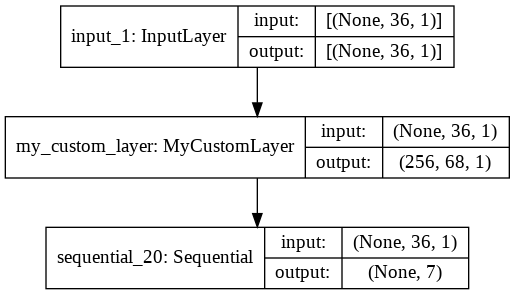

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

![picture](https://lh3.googleusercontent.com/fife/ABSRlIpCpzqWnpfyfMaVN0pTag5ll9SAaFRt1mn_CEZ1h6Fh0WvgvdQucuqOUKhjDMhyMoRU3504OxVt4uuuRzNZHce_Rhk6CocvhzwzLHFy2PKzwJCvhiLAf2Bozl1uQ9AZ7Y8R6c5UDYIJ1Bn6TBUYdCEa2YkIo5mUp_WLQJ-w7UFtdFbPDuBk9QkjomDfSPAhMjRCnDPXpBrCoOJxQuodbWwMC6VHs3QIHLtgCX0TbX1NgfWjJ9114yaSD0n8asB9x3pMdyYYi8sVj_UPwqivVpx5bG1qImFKDKF1CaxWzScLsf4nKyG9Ap02KBHdz1HrkUU03KKbN4FQI2Teb9lLkPomM3AtOkNBtl3KhJB8upPEEHOxWWgAOCGiR7HO5LVvKVHxLzy3WT3ukBKdz533Zy8KF_Qht4o2VUB-Fs9RmYvuEpuj_60vHtSXA13rnFz5UW3Ie7K586DCOdaDrpBvXvVFmJHuU_FRAtkiq1YfvTr-G3AG8sbv5qk9X6SeK7UzyeTdMu1a58gbxRrSMBQn_PHY3479Kpb6R9xpPI6frPn8snURo_ZJY6TJeFl0EYANdLE22DMHqfOfMQOAJSScXhUS02xFxrkk8B597jh3WuEH-WYxMdd9utvpqZN1jYfM3uKGGu4jmsI-3LYPDtp8-ikxqcFDeIaWahkxTdgaGliYG-aX6vZ1Ainfr4ct5UwZVI-2qzZ4Gv4XPpUN9yv_imlgc35wZKUStN8=w1854-h1006-ft)